In [ ]:
import os
import math
import random
import numpy as np
import torch

import matplotlib.pyplot as plt  # <-- for plotting
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes
# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes
Using device: cpu


# Enviroment

In [ ]:


# ----------------------
# Vectorized Environment
# ----------------------
class OpinionEnvVectorized:
    """
    A vectorized environment that runs multiple "opinion dynamics" simulations in parallel,
    all on the GPU. This version removes most Python loops in favor of batched operations.
    """

    def __init__(self,
                 num_envs=32,
                 N=1000,
                 M=10,
                 terminal_time=200,
                 bM=4,
                 b=20,
                 noise_level=0.1,
                 duration=1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta_1=1,
                 eta_2=1,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        """
        num_envs: Number of parallel environments
        N: Number of agents per environment
        M: Size for "media dimension"
        """
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.duration = duration
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta_1 = eta_1
        self.eta_2 = eta_2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for "s" (shape [num_envs, N])
        Beta = torch.distributions.beta.Beta(beta_1, beta_2)

        # Shared across all envs: media positions y_m in [-1,1], shape [M]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Storage for environment states: x, c, t, s
        # x: shape [num_envs, N]
        # c: shape [num_envs, M]
        # t: shape [num_envs]
        # s: shape [num_envs, N] (sampled from Beta)
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = Beta.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm=torch.zeros((self.num_envs,self.N,self.M),device=device)

        self.reset()

    def reset(self):
        """Reset all envs to an initial state."""
        with torch.no_grad():
            # x in [-1,1]
            self.x.uniform_(-1.0, 1.0)
            self.AEm.fill_(0.0)
            # c init = 1
            self.c.fill_(1.0)
            # time = 0
            self.t.zero_()
            # If you want to re-sample s from Beta on every reset, uncomment:
            Beta = torch.distributions.beta.Beta(3, 2)
            self.s = Beta.sample(sample_shape=(self.num_envs, self.N)).to(device)
        return self.state2obs()

    def state2obs(self):
        """
        Construct an observation vector of shape [num_envs, nbins + M].
        - nbins: histogram of x per environment
        - c: The M-dimensional credibility vector
        """
        obs_list = []
        # We'll do a manual histogram on GPU
        for i in range(self.num_envs):
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N  # normalize
            obs_list.append(torch.cat([hist_i, self.c[i]]))  # [nbins+M]
        obs = torch.stack(obs_list, dim=0)  # [num_envs, nbins+M]
        return obs


    def step(self, action_pl_ids, action_op_ids):
        """
        Step all environments by 1 "duration" block.
        Returns:
          next_obs: [num_envs, obs_dim]
          rewards:  [num_envs]
          done:      [num_envs] boolean
          info:      None
        """
        with torch.no_grad():
            # decode actions into [num_envs, M//2]
            pl_vec = action_pl_ids
            op_vec = action_op_ids
            # combine to shape [num_envs, M]
            action = torch.cat([pl_vec, op_vec], dim=1)

            # DM => [num_envs, N, M]
            DM = self.ym.view(1, 1, -1) - self.x.unsqueeze(2)
            # D => [num_envs, N, N]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1, 2)  # shape [num_envs, N, N]

            fac = (1.0 + self.eta_1 * action).unsqueeze(1) * \
                  (1.0 + self.eta_2 * (2 - self.c -action).unsqueeze(1) * (1.0 - self.s).unsqueeze(2))
            AM = torch.exp(-self.bM * fac * torch.abs(DM))  # [num_envs, N, M]
            A  = torch.exp(-self.b  * torch.abs(D))         # [num_envs, N, N]
            self.AEm += torch.exp(-self.bM * torch.abs(DM))* (1-action.unsqueeze(1))
            self.media_attention=AM
            self.action=action
            self.fac=fac
            self.DM=DM
            # Update c using "c = c * gamma + action*(1-gamma)"
            self.c = self.c * self.lambda_c + action * (1 - self.lambda_c)

            # Weighted updates for x
            x_update_social = -(A * D).sum(dim=2) / A.sum(dim=2).clamp_min(1e-12)
            x_update_media  = (AM * DM).sum(dim=2) / AM.sum(dim=2).clamp_min(1e-12)

            # Euler step with noise
            noise = torch.normal(
                mean=0.0, std=self.noise_level,
                size=(self.num_envs, self.N),
                device=device
            )
            update = self.x + self.h * (x_update_social + x_update_media) + torch.sqrt(self.h) * noise
            # update = self.x + self.h * (x_update_media) + torch.sqrt(self.h) * noise
            self.x=update
            self.t += 1

            # Reward
            sin_term = torch.sin(self.pi * self.x / 2.0)
            sin_pow = sin_term.pow(5)
            mean_sin_pow = sin_pow.mean(dim=1)
            reward = self.r_scale * (-1.0 * mean_sin_pow)

            # done
            done = (self.t >= self.terminal_time)

        next_obs = self.state2obs()
        return next_obs, reward, done, None

In [ ]:
#########################################
#  1) Setup the device for CUDA
#########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#########################################
#  2) Create Environment
#########################################
N = 500
M = 10
env = OpinionEnvVectorized(
    num_envs=1,
    N=N,
    M=M,
    terminal_time=401,
    bM=5,
    b=20,
    noise_level=0.1,
    duration=1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta_1=1,
    eta_2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)

plt_type='normal'
# plt_type='real'
#########################################
#          Dynamic Loop                 #
#########################################
# setting up the actions
env.reset()
opinon_data=torch.zeros([env.num_envs,N,env.terminal_time],device=device)
# suceptiblity_data=torch.zeros([env.num_envs,N,env.terminal_time+1],device=device)
for t in range(env.terminal_time):
    if plt_type=='normal':
        actions = torch.bernoulli(.9 - 0.8*1e-8 * env.ym.repeat(env.num_envs,1) ** 2).to(device)
    elif plt_type=='real':
      actions = torch.bernoulli(.9 - 0.8*1e-0 * env.ym.repeat(env.num_envs,1) ** 2).to(device)
    action_u=actions[:,:int(M/2)]
    action_v=actions[:,int(M/2):]
    next_obs, reward, done, _ = env.step(action_u, action_v)
    opinon_data[:,:,t]=env.x

Using device: cpu


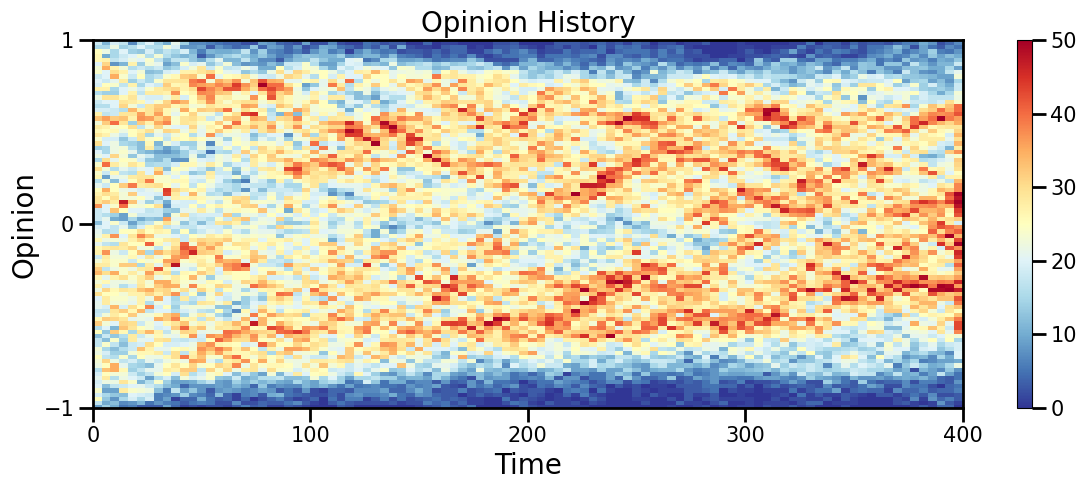

In [ ]:
os.makedirs('trajectory_plots',exist_ok=True)

x_data = opinon_data.reshape(-1, env.terminal_time).cpu().numpy()

# We can create a "time" array of shape [T+1], then broadcast.
t_range = np.arange(env.terminal_time)

# ====================================================
# 1) 2D Histogram (All Envs, All Agents)
# ====================================================
fig, ax = plt.subplots(figsize=(12, 5))
# Flatten into 1D for time, 1D for opinions:
# We replicate each time step for all agents to match shape
# x_data has shape [num_envs*N, T+1].
# We'll flatten as well:
num_total = x_data.shape[0]  # num_envs*N
# For each time step, we have "num_total" opinions.
# So let's tile the time steps to match that flattening:
T_flat = np.tile(t_range, num_total)
X_flat = x_data.flatten()

cax = sns.histplot(x=T_flat, y=X_flat, fill=True, cmap="RdYlBu_r", bins=100, thresh=None, ax=ax)
quadmesh = cax.collections[0]
quadmesh.set_clim(0, 50)
cbar = plt.colorbar(cax.collections[0], ax=ax, aspect=25)
cbar.ax.tick_params(labelsize=15, width=2, length=10)
cbar.ax.set_yticks([0, 10, 20, 30, 40,50])

ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_ylim(-1, 1)
ax.set_xlim(0, env.terminal_time-1)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([0, 100, 200,300,400])
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Opinion", fontsize=20)
ax.set_title("Opinion History", fontsize=20)

plt.tight_layout()
plt.savefig( f"trajectory_plots/op_hist_{plt_type}.svg", dpi=300)
plt.show()
plt.close()

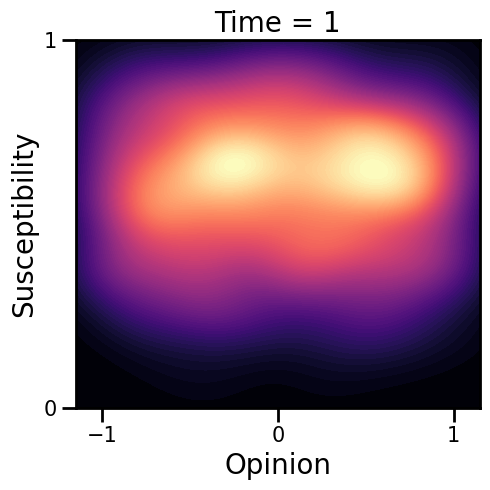

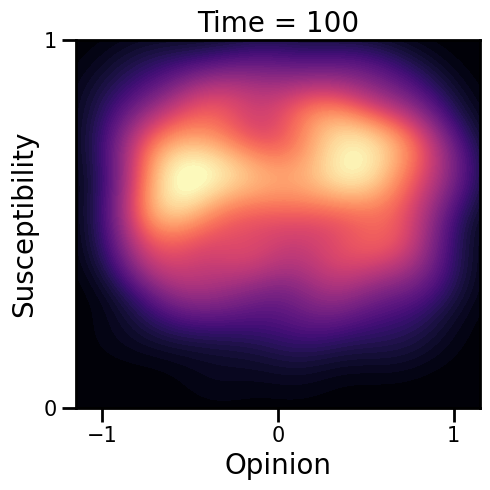

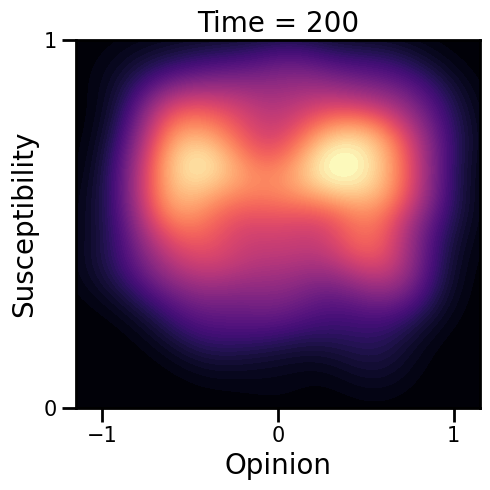

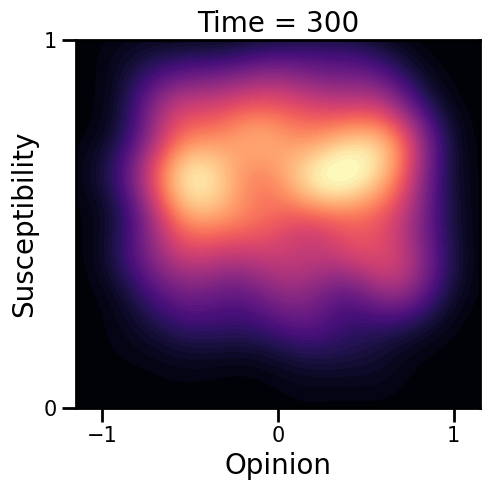

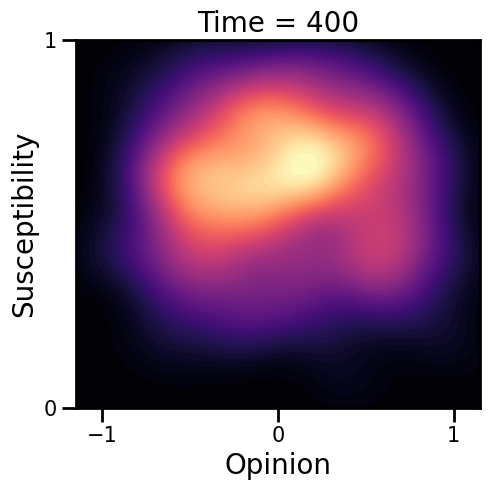

In [ ]:
# KDE Plot for Different Time Indices
time_indices = [1, 100, 200,300,400]
for t_idx in time_indices:
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(x=opinon_data[0,:, t_idx-1], y=env.s[0].squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)

    ax.set_xlim([-1.15, 1.15])
    ax.set_ylim(0, 1)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
    ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.set_title(f"Time = {t_idx}", fontsize=20)
    ax.set_xlabel("Opinion", fontsize=20)
    ax.set_ylabel("Susceptibility", fontsize=20)

    plt.tight_layout()
    plt.savefig(f"trajectory_plots/xs_kde{t_idx:03}_{plt_type}.svg", dpi=300)
    plt.show()
    plt.close()

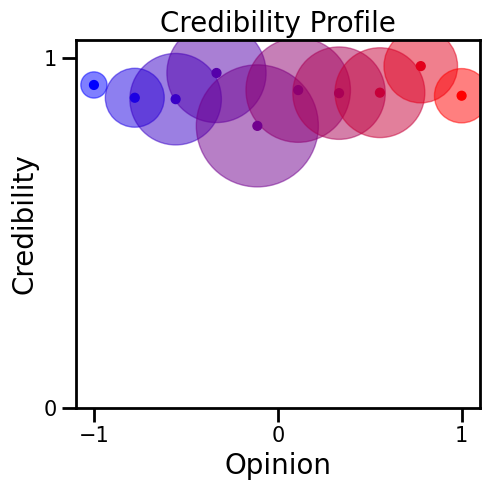

In [ ]:
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
fig, ax = plt.subplots(figsize=(5, 5))
size=env.media_attention.sum(axis=1)[0].cpu().numpy()
# size[size<3]=3
size*=80
ax.scatter(env.ym.cpu(), env.c[0].cpu().numpy(), s=size, c=env.ym.cpu(), cmap=cmap, alpha=.5)
ax.scatter(env.ym.cpu(), env.c[0].cpu().numpy(), s=40, c=env.ym.cpu(), cmap=cmap, alpha=1)

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([0, 1.05])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_title("Credibility Profile", fontsize=20)
ax.set_xlabel("Opinion", fontsize=20)
ax.set_ylabel("Credibility", fontsize=20)

plt.tight_layout()
plt.savefig(f"trajectory_plots/cx_circ_{plt_type}.svg", dpi=300)
plt.show()
plt.close()

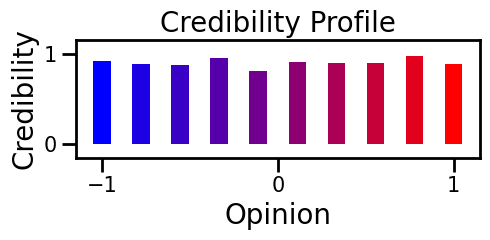

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create the custom blue-red colormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)

# Assume that env.ym and env.c[0] are available from your environment
# Convert tensor data to numpy arrays (or adjust if they are already numpy arrays)
opinions = env.ym.cpu().numpy()            # x-values (Opinion)
credibility = env.c[0].cpu().numpy()         # y-values (Credibility)

# Normalize opinion values for the colormap.
# Since your x-axis limits are [-1.15, 1.15], we use -1 and 1 for normalization.
norm = plt.Normalize(vmin=-1, vmax=1)
bar_colors = cmap(norm(opinions))

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 2.5))

# Choose a bar width (you may adjust this value)
bar_width = 0.1

# Create the bar plot
ax.bar(opinions, credibility, width=bar_width, color=bar_colors, align='center')

# Set the limits, ticks, and styling as before
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set titles and labels
ax.set_title("Credibility Profile", fontsize=20)
ax.set_xlabel("Opinion", fontsize=20)
ax.set_ylabel("Credibility", fontsize=20)

# Adjust layout and save/show the figure
plt.tight_layout()
plt.savefig(f"lim/cx_bar_{plt_type}.svg", dpi=300)
plt.show()
plt.close()


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)
fig,ax=plt.subplots(figsize=(5,5))
env_rand=np.random.randint(0,env.num_envs)
x=env.x.squeeze().cpu().numpy().flatten()
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=1,alpha=.1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time
           ,x=x[x>0].mean(),s=500,alpha=1,c=[.4,0,0],marker='*',linewidths=1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x<0].mean()/env.terminal_time
           ,x=x[x<0].mean(),s=500,alpha=1,c='tab:cyan',marker='*',linewidths=1)
# ax.scatter(y=env.AEm[env_rand,:,:].sum(axis=1).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=10,alpha=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.6)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Exposure.svg",dpi=300)
plt.show()
plt.close()

NameError: name 'LinearSegmentedColormap' is not defined